In [1]:
import numpy as np 
import pandas as pd 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings(action="ignore")
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('data.csv', header= 0,
                        encoding= 'unicode_escape')
df.head ()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving data.csv to data.csv


,ï»¿,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,â¬110.5M,â¬565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,â¬226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,â¬77M,â¬405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,â¬127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,â¬118.5M,â¬290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,â¬228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,â¬72M,â¬260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,â¬138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,â¬102M,â¬355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,â¬196.4M


In this analysis we will try to create a prediction on how much wage should a player expect depending on various attributes they have including but not limited to nationality, position, age and overall (ovarall ability score over) etc. Alternatively we can see how much should a team be paying for a player by checking Value. 

# 1- First a cleaning of the data would be necessary. 

We need to see 

In [40]:
fifa = df.copy()
fifa.head (3)

,ï»¿,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,â¬110.5M,â¬565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,â¬226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,â¬77M,â¬405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,â¬127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,â¬118.5M,â¬290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,â¬228.1M


First we get rid of columns we will not need

In [41]:
fifa_dropped = fifa.drop(columns=["Photo", "Flag","Club Logo","Special","Body Type","Real Face","Loaned From","Release Clause","Joined","ï»¿","Contract Valid Until"])
fifa_dropped.head(3)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,â¬110.5M,â¬565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,10.0,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,â¬77M,â¬405K,Right,5.0,4.0,5.0,High/ Low,ST,7.0,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,â¬118.5M,â¬290K,Right,5.0,5.0,5.0,High/ Medium,LW,10.0,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0


Now lets see how much null data we have

In [42]:
fifa_dropped.isnull().sum()


ID                0
Name              0
Age               0
Nationality       0
Overall           0
                 ..
GKDiving         48
GKHandling       48
GKKicking        48
GKPositioning    48
GKReflexes       48
Length: 78, dtype: int64

Handle null values. The first issue to tackle is the non-numeric notation of Wage and Value (I did not believe we needed Release Clause). We need remove the non numeric characters and make them numeric if they are not.

As we will work with Wage and Wage as it is needs to be only numerical we will clean it

In [43]:
type (fifa_dropped ['Wage'])

pandas.core.series.Series

In [44]:
type (fifa_dropped ['Value'])

pandas.core.series.Series

for Value there are both K (thousand) and M (Million). In this case if we are going to change Value we will also have to do it for Wage. In this case we will create a formula. 

In [45]:
fifa_dropped['Value'] = fifa_dropped['Value'].str.strip('â¬')
fifa_dropped['Wage'] =  fifa_dropped['Wage'].str.strip('â¬')
fifa_dropped.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110.5M,565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,10.0,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77M,405K,Right,5.0,4.0,5.0,High/ Low,ST,7.0,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5M,290K,Right,5.0,5.0,5.0,High/ Medium,LW,10.0,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,De Gea,27,Spain,91,93,Manchester United,72M,260K,Right,4.0,3.0,1.0,Medium/ Medium,GK,1.0,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102M,355K,Right,4.0,5.0,4.0,High/ High,RCM,7.0,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [46]:
def converter(val):
    lookup = {'K': 1000, 'M': 1000000, '0':1}
    if type(val) != float:
        unit = val[-1]
        if unit in lookup:
            number = pd.to_numeric(val[:-1])
        return lookup[unit] * number
    return val

In [47]:
fifa_dropped['Value_clean'] = fifa_dropped['Value'].apply(converter)
fifa_dropped['Wage_clean'] = fifa_dropped['Wage'].apply(converter)

fifa_dropped[['Value_clean', 'Wage_clean']].head(3)

,Value_clean,Wage_clean
0,110500000.0,565000.0
1,77000000.0,405000.0
2,118500000.0,290000.0


In [48]:
fifa_dropped.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value_clean,Wage_clean
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110.5M,565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,10.0,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110500000.0,565000.0
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77M,405K,Right,5.0,4.0,5.0,High/ Low,ST,7.0,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,77000000.0,405000.0
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5M,290K,Right,5.0,5.0,5.0,High/ Medium,LW,10.0,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118500000.0,290000.0
3,193080,De Gea,27,Spain,91,93,Manchester United,72M,260K,Right,4.0,3.0,1.0,Medium/ Medium,GK,1.0,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,72000000.0,260000.0
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102M,355K,Right,4.0,5.0,4.0,High/ High,RCM,7.0,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,102000000.0,355000.0


In [49]:
pd.to_numeric(fifa_dropped ['Wage_clean'])

0        565000.0
1        405000.0
2        290000.0
3        260000.0
4        355000.0
           ...   
18202      1000.0
18203      1000.0
18204      1000.0
18205      1000.0
18206      1000.0
Name: Wage_clean, Length: 18207, dtype: float64

In [50]:
pd.to_numeric(fifa_dropped ['Value_clean'])

0        110500000.0
1         77000000.0
2        118500000.0
3         72000000.0
4        102000000.0
            ...     
18202        60000.0
18203        60000.0
18204        60000.0
18205        60000.0
18206        60000.0
Name: Value_clean, Length: 18207, dtype: float64

For our future checks we will use Wage_clean and Value_clean.

A few things show to be a problem, first is the unnecessarily detailed distribution of positions, I will regroup them as Goalkeeper, Defence, Midfield and Forward. Same with the age groups. Another fixing point is the "88+2" notation for the positional abilities. I will have them as already added up. 

In [51]:
fifa_dropped['Position'].value_counts()


ST     2152
GK     2025
CB     1778
CM     1394
LB     1322
RB     1291
RM     1124
LM     1095
CAM     958
CDM     948
RCB     662
LCB     648
LCM     395
RCM     391
LW      381
RW      370
RDM     248
LDM     243
LS      207
RS      203
RWB      87
LWB      78
CF       74
LAM      21
RAM      21
RF       16
LF       15
Name: Position, dtype: int64

I will create a dictionary first to implement the simple positions

In [52]:
dict_position = {
    'Goal': ['GK'],
    'Defence': ['LWB', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'],
    'Midfield': ['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 
                   'RCM', 'RM', 'LDM', 'CDM', 'RDM'],
    'Forward': ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
}

Lets get rid of null values in Value and Wage

In [53]:
fifa_dropped['Position'].isnull().sum()


60

In [100]:
fifa_dropped.dropna(subset=['Value', 'Wage'], inplace= True)
fifa_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18207 entries, 0 to 18206
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18207 non-null  int64  
 1   Name                      18207 non-null  object 
 2   Age                       18207 non-null  int64  
 3   Nationality               18207 non-null  object 
 4   Overall                   18207 non-null  int64  
 5   Potential                 18207 non-null  int64  
 6   Club                      17966 non-null  object 
 7   Value                     18207 non-null  object 
 8   Wage                      18207 non-null  object 
 9   Preferred Foot            18159 non-null  object 
 10  International Reputation  18159 non-null  float64
 11  Weak Foot                 18159 non-null  float64
 12  Skill Moves               18159 non-null  float64
 13  Work Rate                 18159 non-null  object 
 14  Positi

In [55]:
def position_simple (position):
    for key in dict_position:
        if position in dict_position[key]:
            return key
        else:
            continue
fifa_dropped['Simple_Position']= fifa_dropped['Position'].apply(position_simple)
fifa_dropped[['Position','Simple_Position']].head(3)


,Position,Simple_Position
0,RF,Forward
1,ST,Forward
2,LW,Forward


Let's do positional skill points before we forget

In [56]:
fifa_dropped.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,...,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value_clean,Wage_clean,Simple_Position
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110.5M,565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,10.0,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,...,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110500000.0,565000.0,Forward
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77M,405K,Right,5.0,4.0,5.0,High/ Low,ST,7.0,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,...,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,77000000.0,405000.0,Forward
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5M,290K,Right,5.0,5.0,5.0,High/ Medium,LW,10.0,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,...,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118500000.0,290000.0,Forward
3,193080,De Gea,27,Spain,91,93,Manchester United,72M,260K,Right,4.0,3.0,1.0,Medium/ Medium,GK,1.0,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,72000000.0,260000.0,Goal
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102M,355K,Right,4.0,5.0,4.0,High/ High,RCM,7.0,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,...,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,102000000.0,355000.0,Midfield


In [57]:
position_list = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
       'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM',
       'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [58]:
def skill (val):
    if type(val) == str:
        s1 = val[0:2]
        s2 = val[-1]
        val = int(s1) + int(s2)
        return val
    
    else:
        return val

In [60]:
for col in position_list:
    fifa_dropped[col] = fifa_dropped[col].apply(skill)

In [61]:
fifa_dropped.head(5)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,...,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value_clean,Wage_clean,Simple_Position
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110.5M,565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,10.0,5'7,159lbs,90.0,90.0,90.0,94.0,95.0,95.0,95.0,94.0,95.0,95.0,95.0,93.0,86.0,86.0,86.0,93.0,66.0,63.0,63.0,63.0,66.0,61.0,...,49.0,49.0,61.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110500000.0,565000.0,Forward
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77M,405K,Right,5.0,4.0,5.0,High/ Low,ST,7.0,6'2,183lbs,94.0,94.0,94.0,92.0,93.0,93.0,93.0,92.0,91.0,91.0,91.0,91.0,84.0,84.0,84.0,91.0,68.0,64.0,64.0,64.0,68.0,64.0,...,56.0,56.0,64.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,77000000.0,405000.0,Forward
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5M,290K,Right,5.0,5.0,5.0,High/ Medium,LW,10.0,5'9,150lbs,87.0,87.0,87.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,91.0,84.0,84.0,84.0,91.0,68.0,63.0,63.0,63.0,68.0,63.0,...,50.0,50.0,63.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118500000.0,290000.0,Forward
3,193080,De Gea,27,Spain,91,93,Manchester United,72M,260K,Right,4.0,3.0,1.0,Medium/ Medium,GK,1.0,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,72000000.0,260000.0,Goal
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102M,355K,Right,4.0,5.0,4.0,High/ High,RCM,7.0,5'11,154lbs,85.0,85.0,85.0,90.0,90.0,90.0,90.0,90.0,91.0,91.0,91.0,91.0,90.0,90.0,90.0,91.0,80.0,80.0,80.0,80.0,80.0,76.0,...,69.0,69.0,76.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,102000000.0,355000.0,Midfield


Let's check for outlying values

Threshold Value: 1
Number of Outliers: 0
------
Threshold Value: 2
Number of Outliers: 0
------
Threshold Value: 3
Number of Outliers: 0
------
Threshold Value: 4
Number of Outliers: 0
------


Now we do Age, I will also do it for Overall. I will categorize them by intervals. 

In [23]:
bins_age = [16, 21, 25, 30, 35, 40, 45]
labels = ['17-21','22-25','26-30','31-35','36-40','41-45']
fifa_dropped['Clustered_age'] = pd.cut(df['Age'], bins=bins_age, labels = labels)
fifa_dropped['Clustered_age']

0        31-35
1        31-35
2        26-30
3        26-30
4        26-30
         ...  
18202    17-21
18203    17-21
18204      NaN
18205    17-21
18206      NaN
Name: Clustered_age, Length: 18207, dtype: category
Categories (6, object): [17-21 < 22-25 < 26-30 < 31-35 < 36-40 < 41-45]

In [24]:
fifa_dropped['OverallByTens'] = pd.cut(x=fifa_dropped['Overall'], bins=[40,49,59,69,79,89,99], labels=['40', '50', '60','70', '80', '90'])
fifa_dropped.head(3)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,...,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value_clean,Wage_clean,Simple_Position,Clustered_age,OverallByTens
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110.5M,565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,10.0,5'7,159lbs,90.0,90.0,90.0,94.0,95.0,95.0,95.0,94.0,95.0,95.0,95.0,93.0,86.0,86.0,86.0,93.0,66.0,63.0,63.0,63.0,66.0,61.0,...,61.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110500000.0,565000.0,Forward,31-35,90
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77M,405K,Right,5.0,4.0,5.0,High/ Low,ST,7.0,6'2,183lbs,94.0,94.0,94.0,92.0,93.0,93.0,93.0,92.0,91.0,91.0,91.0,91.0,84.0,84.0,84.0,91.0,68.0,64.0,64.0,64.0,68.0,64.0,...,64.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,77000000.0,405000.0,Forward,31-35,90
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5M,290K,Right,5.0,5.0,5.0,High/ Medium,LW,10.0,5'9,150lbs,87.0,87.0,87.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,91.0,84.0,84.0,84.0,91.0,68.0,63.0,63.0,63.0,68.0,63.0,...,63.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118500000.0,290000.0,Forward,26-30,90


We will start by checking how wage is distributed by nationality. As there are a lot more countries than we would like to examine we will limit it to the top 10 nationalities. In this context we will choose the countries with the highest number of values:

In [25]:
fifa_dropped.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Position', 'Jersey Number',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Value_clean', 'Wage_clean',
       'Simple_Position', 'Clu

In [26]:
topten_nationality = fifa_dropped['Nationality'].value_counts().head(9).index.values
fifa_ten = fifa_dropped.loc[fifa_dropped['Nationality'].isin(topten_nationality), :]

Also filling NaN values with average will benefit us

In [27]:
fifa_ten['Wage_clean'].fillna(fifa_ten['Wage_clean'].mean(), inplace=True)

# EDA

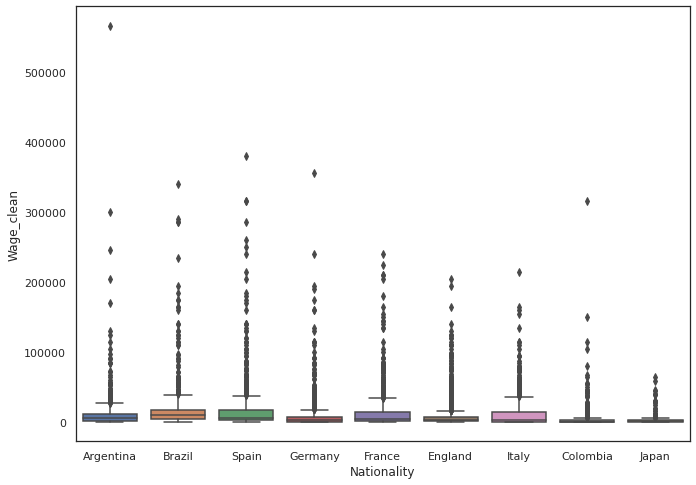

In [28]:
sns.set(style="white")
plt.figure(figsize=(11, 8))
p = sns.boxplot(x = 'Nationality', y = 'Wage_clean', data = fifa_ten)

We see that the Brazilian and Spanish players to be the highest earners. So who are the highest earners?

In [29]:
fifa_ten ['Wage_clean'] = fifa_ten ['Wage_clean'].astype(float)
Wage_top_ten = fifa_ten[['Name','Wage_clean']].nlargest(10, ['Wage_clean']) 
Wage_top_ten

,Name,Wage_clean
0,L. Messi,565000.0
8,Sergio Ramos,380000.0
11,T. Kroos,355000.0
32,Coutinho,340000.0
20,Sergio Busquets,315000.0
28,J. RodrÃ­guez,315000.0
30,Isco,315000.0
23,S. AgÃ¼ero,300000.0
2,Neymar Jr,290000.0
13,David Silva,285000.0


In [30]:
fifa_ten ['Value_clean'] = fifa_ten ['Value_clean'].astype(float)
Value_top_ten = fifa_ten[['Name','Value_clean']].nlargest(10, ['Value_clean']) 
Value_top_ten

,Name,Value_clean
2,Neymar Jr,118500000.0
0,L. Messi,110500000.0
15,P. Dybala,89000000.0
16,H. Kane,83500000.0
25,K. MbappÃ©,81000000.0
17,A. Griezmann,78000000.0
11,T. Kroos,76500000.0
30,Isco,73500000.0
3,De Gea,72000000.0
28,J. RodrÃ­guez,69500000.0


Now for age, as age is relatively finite (most players are between 16 to 41) I will not categorize them, however this might be needed when we do value. 

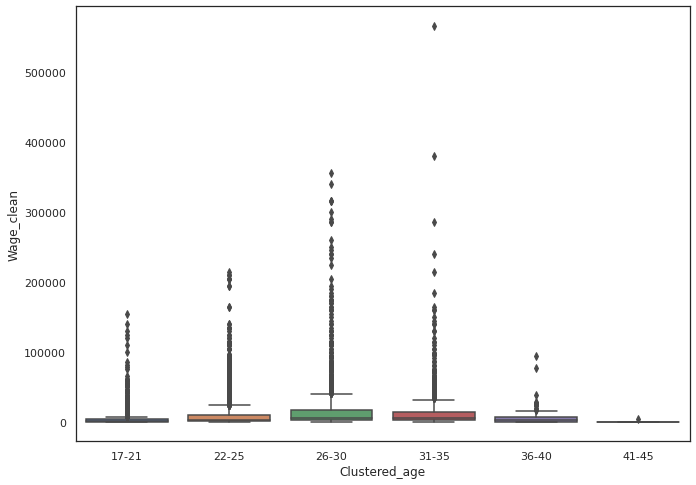

In [31]:
sns.set(style="white")
plt.figure(figsize=(11, 8))
p = sns.boxplot(x = 'Clustered_age', y = 'Wage_clean', data = fifa_ten)

The highest wage is seen with 26-30 year olds in the top 10 countries. Lets see positions, similar to age position despite having a lot of categories is still finite and will see it:

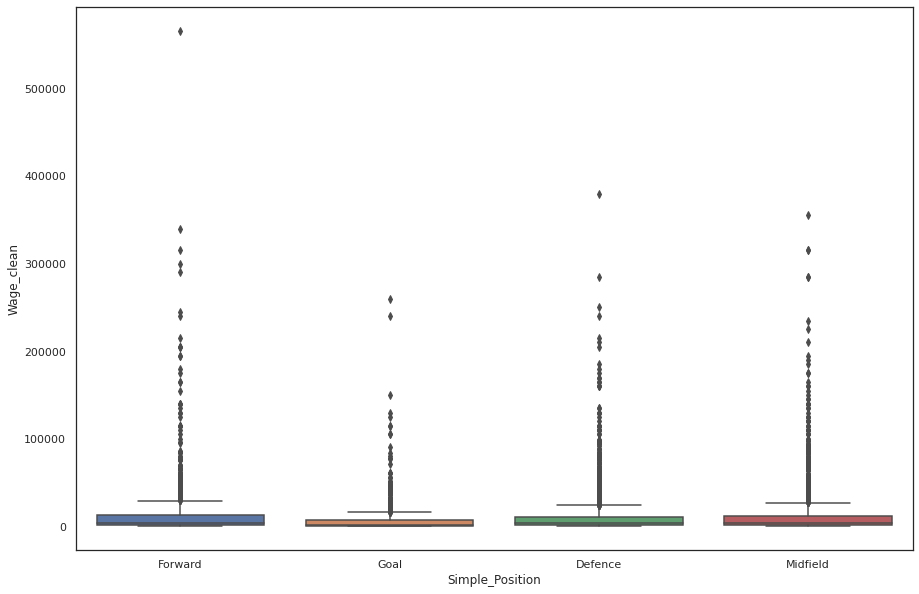

In [32]:
sns.set(style="white")
plt.figure(figsize=(15,10))
p = sns.boxplot(x = 'Simple_Position', y = 'Wage_clean', data = fifa_ten)

It shows that forwards earn the highest wage. 

Not much of significance. How about value. How does overall affect the wage? In contrast to the other values the value intervals are almost infinite with this. As such needs to be categorized into bins of 10. 

In [33]:
fifa_ten ['Overall'].max()


94

In [34]:
fifa_ten ['Overall'].min()


46

In [35]:
topten_nationality = fifa_ten['Nationality'].value_counts().head(10).index.values
topten_nationality_dt = fifa_ten.loc[fifa_ten['Nationality'].isin(topten_nationality), :]

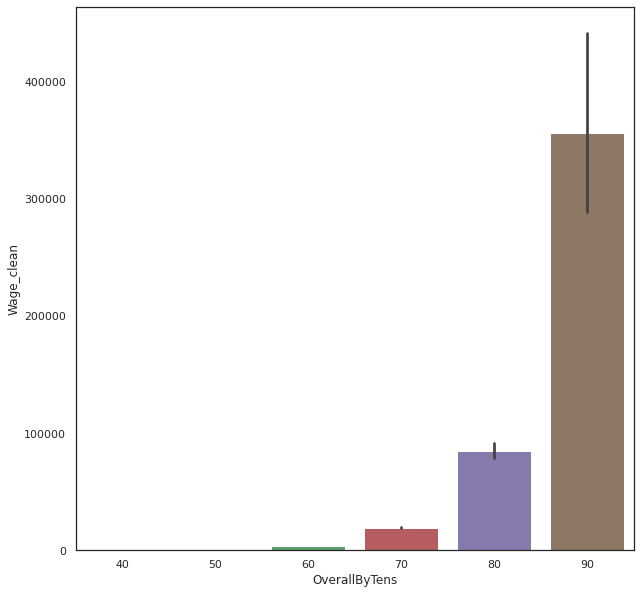

In [36]:
sns.set(style="white")
plt.figure(figsize=(10,10))
p = sns.barplot(x = 'OverallByTens', y = 'Wage_clean', data = topten_nationality_dt)

This shows that to get a very top wage you have to be over 90 (or 80 if you want good one)

In [37]:
fifa_ten.head(3)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,...,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value_clean,Wage_clean,Simple_Position,Clustered_age,OverallByTens
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110.5M,565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,10.0,5'7,159lbs,90.0,90.0,90.0,94.0,95.0,95.0,95.0,94.0,95.0,95.0,95.0,93.0,86.0,86.0,86.0,93.0,66.0,63.0,63.0,63.0,66.0,61.0,...,61.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110500000.0,565000.0,Forward,31-35,90
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5M,290K,Right,5.0,5.0,5.0,High/ Medium,LW,10.0,5'9,150lbs,87.0,87.0,87.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,91.0,84.0,84.0,84.0,91.0,68.0,63.0,63.0,63.0,68.0,63.0,...,63.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118500000.0,290000.0,Forward,26-30,90
3,193080,De Gea,27,Spain,91,93,Manchester United,72M,260K,Right,4.0,3.0,1.0,Medium/ Medium,GK,1.0,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,72000000.0,260000.0,Goal,26-30,90


Despite the expected result of having higher Value having such an impact on wage is good to know. As there seems to be a trend in regards to teams with the highest Value and Wage. Let's see the teams with the highest values.

In [38]:
club_group = fifa_ten[['Value_clean','Wage_clean']].groupby(fifa_ten['Club']).sum()
top_ten_club_group = club_group.nlargest(10,'Value_clean')
top_ten_club_group

,Value_clean,Wage_clean
Club,,
FC Barcelona,655500000.0,3527000.0
Real Madrid,634925000.0,3621000.0
Manchester City,554705000.0,2712000.0
FC Bayern MÃ¼nchen,538525000.0,1820000.0
Paris Saint-Germain,533125000.0,1783000.0
Juventus,455475000.0,2105000.0
Chelsea,430015000.0,2433000.0
AtlÃ©tico Madrid,405525000.0,1006000.0
Manchester United,396575000.0,2239000.0


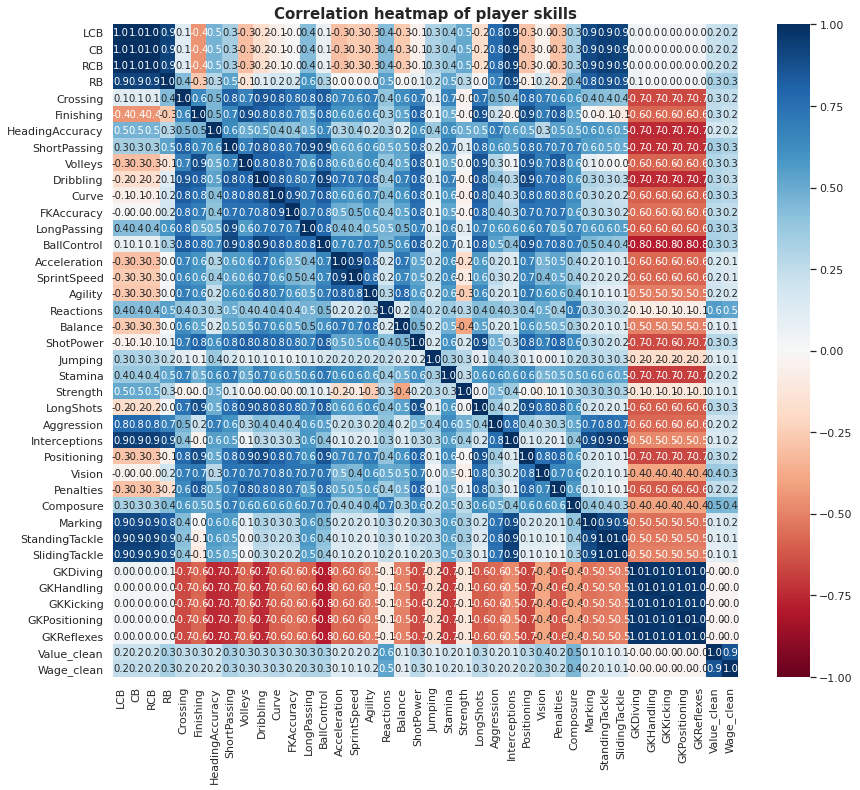

In [118]:
corr_matrix=fifa_ten.iloc[:, 40:85].corr()
# plot it
plt.figure(figsize= (14,12))
plt.title('Correlation heatmap of player skills', fontsize = 15, weight = 'bold')
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True, fmt = '.1f', 
            annot_kws={"size": 10})

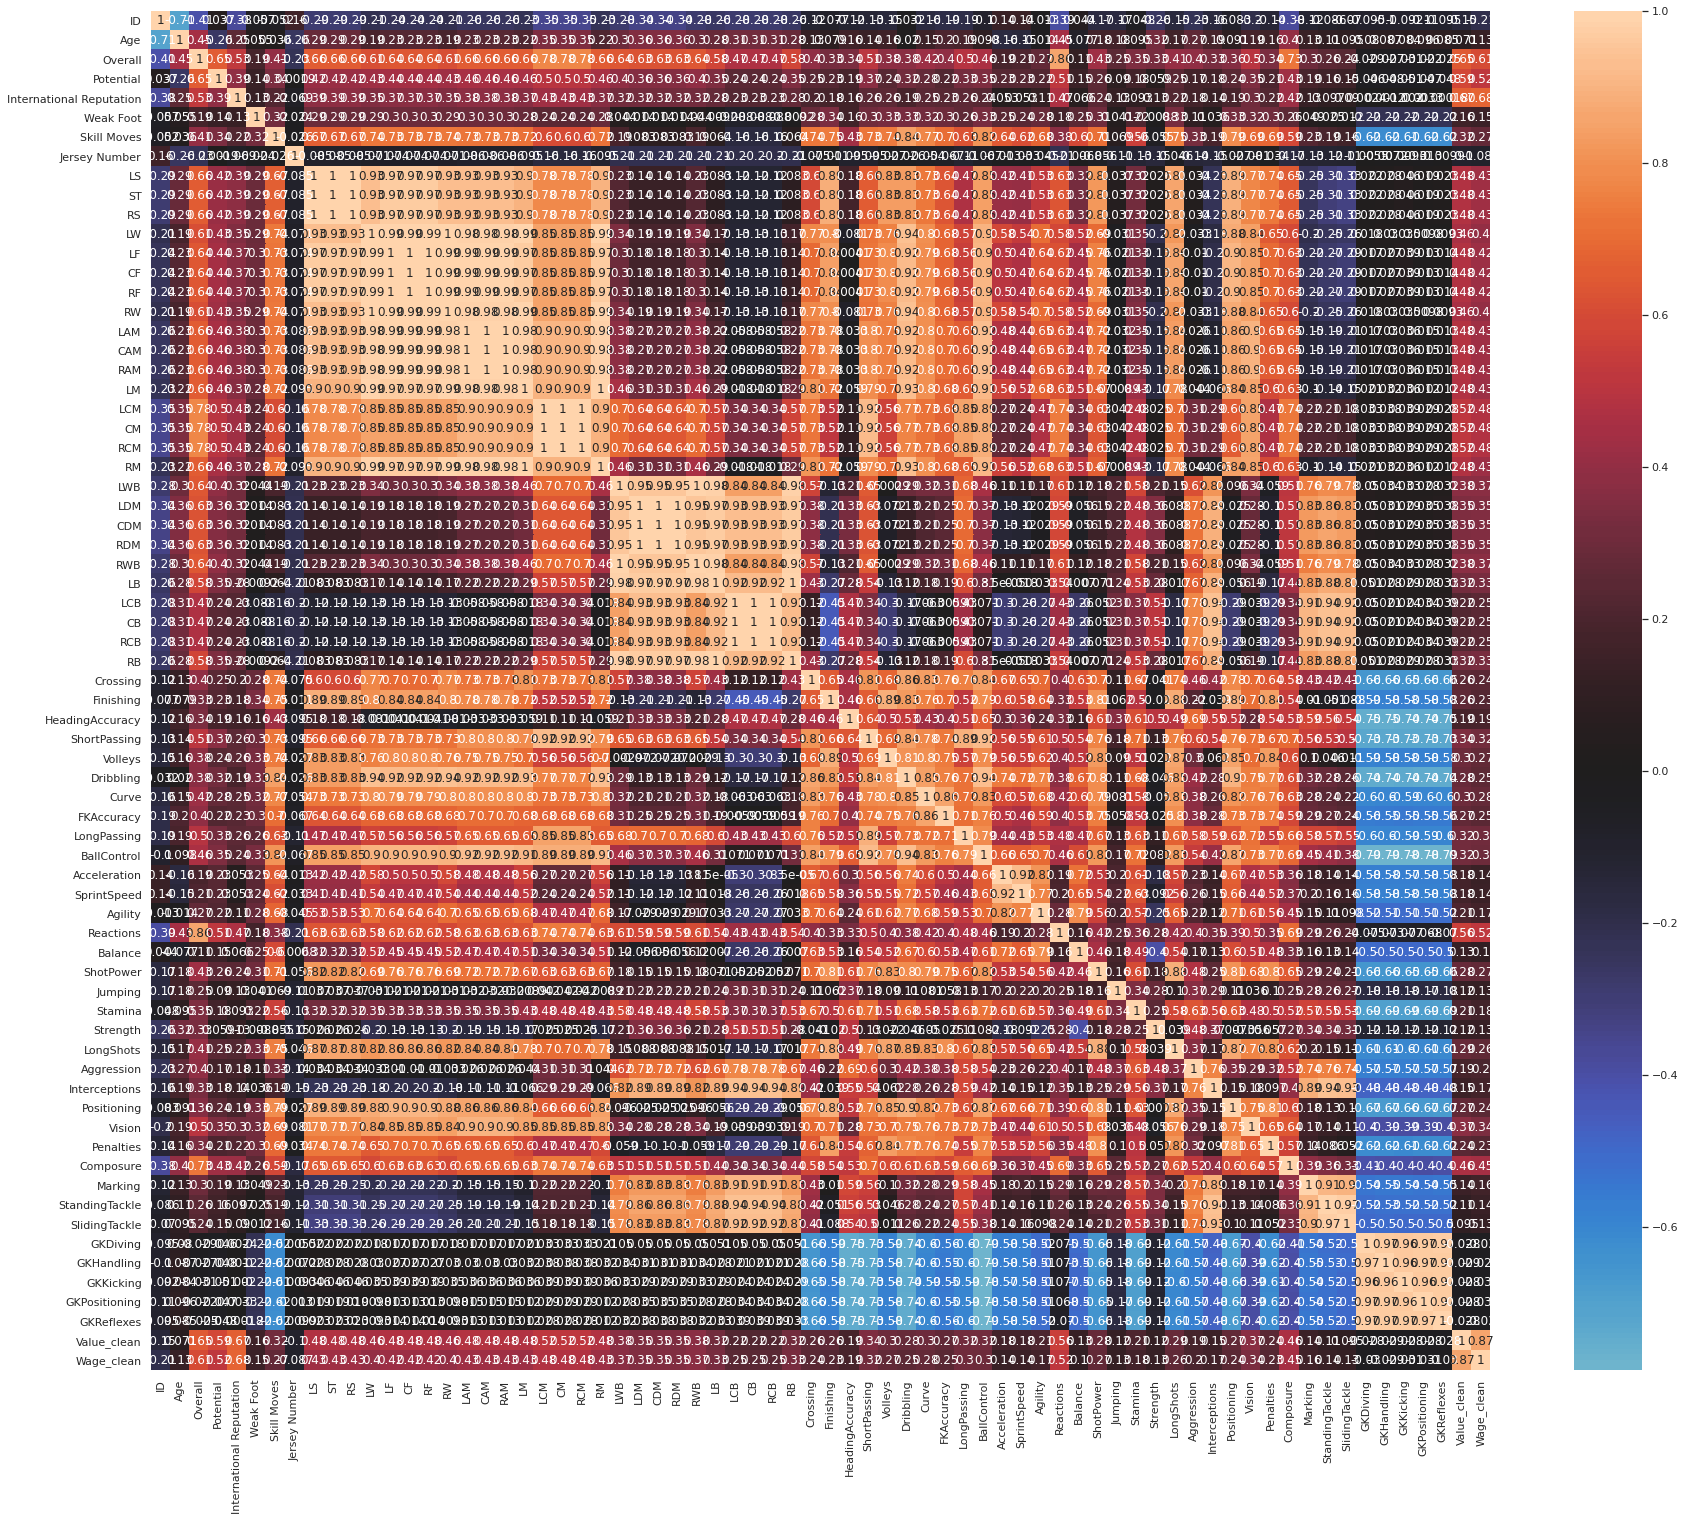

In [75]:
plt.figure(figsize=(30,25))
fifa_corr = fifa_ten.corr()
ax = sns.heatmap(fifa_corr, center=0, annot = True)


# Regression

As we are trying to predict a virtually continious outcome we will use regression for prediction. 

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [114]:
fifa_ten.iloc[:, 44:78]

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
8,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0
11,88.0,76.0,54.0,92.0,82.0,81.0,86.0,84.0,93.0,90.0,64.0,62.0,70.0,89.0,71.0,87.0,30.0,75.0,73.0,92.0,60.0,82.0,79.0,86.0,73.0,85.0,72.0,79.0,69.0,10.0,11.0,13.0,7.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18198,14.0,8.0,14.0,19.0,8.0,10.0,13.0,10.0,21.0,11.0,18.0,24.0,22.0,36.0,47.0,26.0,56.0,20.0,38.0,5.0,25.0,6.0,5.0,37.0,14.0,34.0,15.0,11.0,13.0,46.0,52.0,58.0,42.0,48.0
18202,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18204,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


In [105]:
fifa_ten['Value_clean'] = fifa_ten ['Value_clean'].fillna(fifa_ten ['Value_clean'].mean())

In [106]:
y = np.log(fifa_ten['Wage_clean'])
X = fifa_ten[['Overall','Age','Simple_Position','Value_clean']]
X.head()

,Overall,Age,Simple_Position,Value_clean
0,94,31,Forward,110500000.0
2,92,26,Forward,118500000.0
3,91,27,Goal,72000000.0
8,91,32,Defence,51000000.0
11,90,28,Midfield,76500000.0


In [107]:
X = pd.get_dummies(X, prefix_sep='__', drop_first=True)
X.head(5)

,Overall,Age,Value_clean,Simple_Position__Forward,Simple_Position__Goal,Simple_Position__Midfield
0,94,31,110500000.0,1,0,0
2,92,26,118500000.0,1,0,0
3,91,27,72000000.0,0,1,0
8,91,32,51000000.0,0,0,0
11,90,28,76500000.0,0,0,1


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 6726
Test kümesindeki gözlem sayısı   : 1682


In [109]:
from sklearn import linear_model
lrm = linear_model.LinearRegression()
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
print('Variables: \n', lrm.coef_)
print('Constant (bias): \n', lrm.intercept_)

Variables: 
 [ 0.1633124  -0.0333093   0.16405922 -0.0403831   0.00745371]
Constant (bias): 
 -1.701513834705926


In [110]:
import statsmodels.api as sm
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Wage_clean   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     3646.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:02:42   Log-Likelihood:                -8631.3
No. Observations:                8408   AIC:                         1.728e+04
Df Residuals:                    8401   BIC:                         1.733e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.8995      0.092     -9.731      0.000      -1.081      -0.718
Overall                       0.1474      0.002     89.770      0.000       0.144       0.151
Age                          -0.0250      0.002    -13.717      0.000      -0.029      -0.021
Value_clean                2.252e-08   1.61e-09     13.999      0.000    1.94e-08    2.57e-08
Simple_Position__Forward      0.1383      0.022      6.417      0.000       0.096       0.181
Simple_Position__Goal        -0.0649      0.026     -2.505      0.012      -0.116      -0.014
Simple_Position__Midfield    -0.0051      0.018     -0.289      0.773      -0.040       0.029
==============================================================================
Omnibus:                      178.633   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.042
Skew:                          -0.257   Prob(JB):                     1.02e-53
Kurtosis:                       3.658   Cond. No.                     8.78e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.78e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

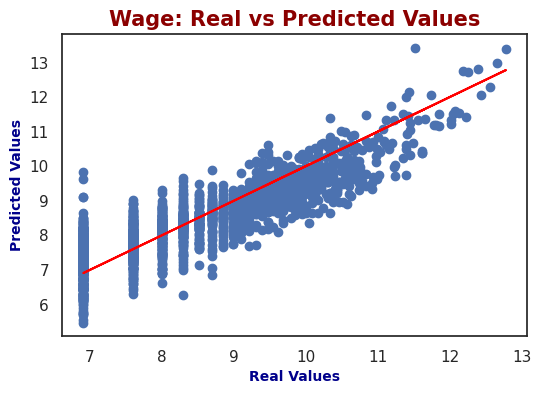

Mean Absolute Error (MAE)        : 0.5148009524408385
Mean Square Error (MSE)          : 0.4196280731105551
Root Mean Square Error (RMSE)     : 0.6477870584617719
Mean Absolute Percentage Error (MAPE) : 6.286194091761245


In [111]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)


title_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
axis_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Real Values", fontdict=axis_font)
plt.ylabel("Predicted Values", fontdict=axis_font)
plt.title("Wage: Real vs Predicted Values", fontdict=title_font)
plt.show()

print("Mean Absolute Error (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean Square Error (MSE)          : {}".format(mse(y_test, y_preds)))
print("Root Mean Square Error (RMSE)     : {}".format(rmse(y_test, y_preds)))
print("Mean Absolute Percentage Error (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Con Considering that one of the biggest factor in wage is the leage the players are in (Premier League will pay more than Turkish Super League). In that regard checking the Value might be a better direction. 

Second Try: Lets try to figure out what ability brings most wages for a player. 

In [133]:
fifa_ten.iloc[:, 44:78] = fifa_ten.iloc[:, 44:78].fillna(fifa_ten.iloc[:, 44:78].mean())

In [134]:
y = np.log(fifa_ten['Wage_clean'])
X = fifa_ten.iloc[:, 44:78]
X.head()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
8,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0
11,88.0,76.0,54.0,92.0,82.0,81.0,86.0,84.0,93.0,90.0,64.0,62.0,70.0,89.0,71.0,87.0,30.0,75.0,73.0,92.0,60.0,82.0,79.0,86.0,73.0,85.0,72.0,79.0,69.0,10.0,11.0,13.0,7.0,10.0


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 6726
Test kümesindeki gözlem sayısı   : 1682


In [136]:
from sklearn import linear_model
lrm = linear_model.LinearRegression()
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [137]:
print('Variables: \n', lrm.coef_)
print('Constant (bias): \n', lrm.intercept_)

Variables: 
 [-0.00084668  0.00576191  0.01652605  0.01306611  0.00241294  0.00999672
  0.00706994 -0.0037553  -0.00506736  0.02026814  0.00530201  0.00609194
 -0.00398689  0.04301817 -0.0053647   0.0057584   0.00029877 -0.00746748
 -0.00097403 -0.00547407  0.00197355  0.00037246 -0.00775309  0.00181702
  0.00060576  0.01948723  0.00226689  0.00242633  0.00329159  0.01087293
  0.0164164   0.00739902  0.0056994   0.0106026 ]
Constant (bias): 
 0.17572648927744794


In [138]:
import statsmodels.api as sm
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Wage_clean   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     408.0
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:10:22   Log-Likelihood:                -9912.8
No. Observations:                8408   AIC:                         1.990e+04
Df Residuals:                    8373   BIC:                         2.014e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1757      0.118      1.487      0.137      -0.056       0.407
Crossing           -0.0008      0.001     -0.732      0.464      -0.003       0.001
Finishing           0.0058      0.001      3.949      0.000       0.003       0.009
HeadingAccuracy     0.0165      0.001     13.513      0.000       0.014       0.019
ShortPassing        0.0131      0.002      6.321      0.000       0.009       0.017
Volleys             0.0024      0.001      1.905      0.057   -6.93e-05       0.005
Dribbling           0.0100      0.002      5.559      0.000       0.006       0.014
Curve               0.0071      0.001      5.683      0.000       0.005       0.010
FKAccuracy         -0.0038      0.001     -3.400      0.001      -0.006      -0.002
LongPassing        -0.0051      0.001     -3.408      0.001      -0.008      -0.002
BallControl         0.0203      0.002      9.012      0.000       0.016       0.025
Acceleration        0.0053      0.002      3.039      0.002       0.002       0.009
SprintSpeed         0.0061      0.002      3.737      0.000       0.003       0.009
Agility            -0.0040      0.001     -3.033      0.002      -0.007      -0.001
Reactions           0.0430      0.002     25.489      0.000       0.040       0.046
Balance            -0.0054      0.001     -4.549      0.000      -0.008      -0.003
ShotPower           0.0058      0.001      4.469      0.000       0.003       0.008
Jumping             0.0003      0.001      0.327      0.744      -0.001       0.002
Stamina            -0.0075      0.001     -7.181      0.000      -0.010      -0.005
Strength           -0.0010      0.001     -0.883      0.377      -0.003       0.001
LongShots          -0.0055      0.001     -4.040      0.000      -0.008      -0.003
Aggression          0.0020      0.001      2.016      0.044    5.47e-05       0.004
Interceptions       0.0004      0.001      0.269      0.788      -0.002       0.003
Positioning        -0.0078      0.001     -5.620      0.000      -0.010      -0.005
Vision              0.0018      0.001      1.432      0.152      -0.001       0.004
Penalties           0.0006      0.001      0.499      0.618      -0.002       0.003
Composure           0.0195      0.001     14.325      0.000       0.017       0.022
Marking             0.0023      0.001      2.089      0.037       0.000       0.004
StandingTackle      0.0024      0.002      1.187      0.235      -0.002       0.006
SlidingTackle       0.0033      0.002      1.729      0.084      -0.000       0.007
GKDiving            0.0109      0.003      4.207      0.000       0.006       0.016
GKHandling          0.0164      0.003      6.176      0.000       0.011       0.022
GKKicking           0.0074      0.002      3.121      0.002       0.003       0.012
GKPositioning       0.0057      0.003      2.216      0.027

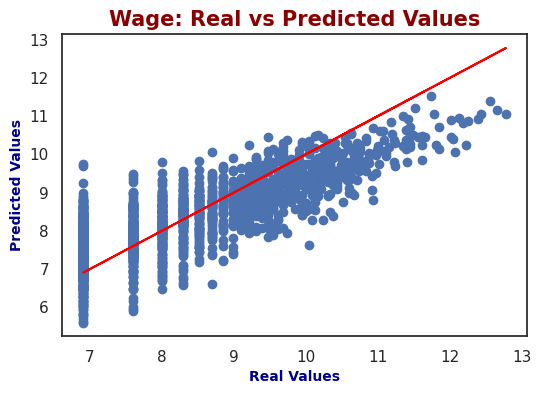

Mean Absolute Error (MAE)        : 0.6075566324967525
Mean Square Error (MSE)          : 0.5840506097363231
Root Mean Square Error (RMSE)     : 0.7642320391977315
Mean Absolute Percentage Error (MAPE) : 7.359653618587301


In [139]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)


title_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
axis_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Real Values", fontdict=axis_font)
plt.ylabel("Predicted Values", fontdict=axis_font)
plt.title("Wage: Real vs Predicted Values", fontdict=title_font)
plt.show()

print("Mean Absolute Error (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean Square Error (MSE)          : {}".format(mse(y_test, y_preds)))
print("Root Mean Square Error (RMSE)     : {}".format(rmse(y_test, y_preds)))
print("Mean Absolute Percentage Error (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

**Conclusion**: 
These abilities had the highest possibility of impact on a higher wage;<p>
short passing, 
finishing,
heading accuracy,
dribbling ,
curve,
ball control,
sprint sped,
reactions,
balance,
shot power,
long shots,
positiong,
composure.  <p>

And among these short passing, dribbling, ball control, reactions and composure had the highest impact on the wage of a player. 

<p>

As the R2 number is just above 0.6 although it is not entirely high accuracy, it means with a few fixes to the model it can be brought to acceptable levels. 


# RANDOM FOREST

In [152]:
y = np.log(fifa_ten['Wage_clean'])
X = fifa_ten.iloc[:, 44:78]
X.head()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
8,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0
11,88.0,76.0,54.0,92.0,82.0,81.0,86.0,84.0,93.0,90.0,64.0,62.0,70.0,89.0,71.0,87.0,30.0,75.0,73.0,92.0,60.0,82.0,79.0,86.0,73.0,85.0,72.0,79.0,69.0,10.0,11.0,13.0,7.0,10.0


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)


In [163]:
fifa_ten.iloc[:, 44:78] = fifa_ten.iloc[:, 44:78].fillna(fifa_ten.iloc[:, 44:78].mean())

In [165]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [170]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = rf.predict(X_test)
print (y_pred)
print ('MAE: {}'.format(mean_absolute_error(y_test,y_pred)))
print ('R2 score: {}'.format(r2_score(y_test, y_pred))) #this is for variance 

[10.69838235  9.98426823  8.70790555 ...  8.76489543  8.64869828
  8.72821285]
MAE: 0.49342811312657975
R2 score: 0.7592437119413913


In [ ]:
önem_dereceleri = pd.Series(data=rastgele_orman.feature_importances_,
                        index= X_eğitim.columns)

önem_dereceleri_sıralı = önem_dereceleri.sort_values()

önem_dereceleri_sıralı.plot(kind='barh', color='darkblue')
plt.title('Değişkenlerin Önem Dereceleri')
plt.show()

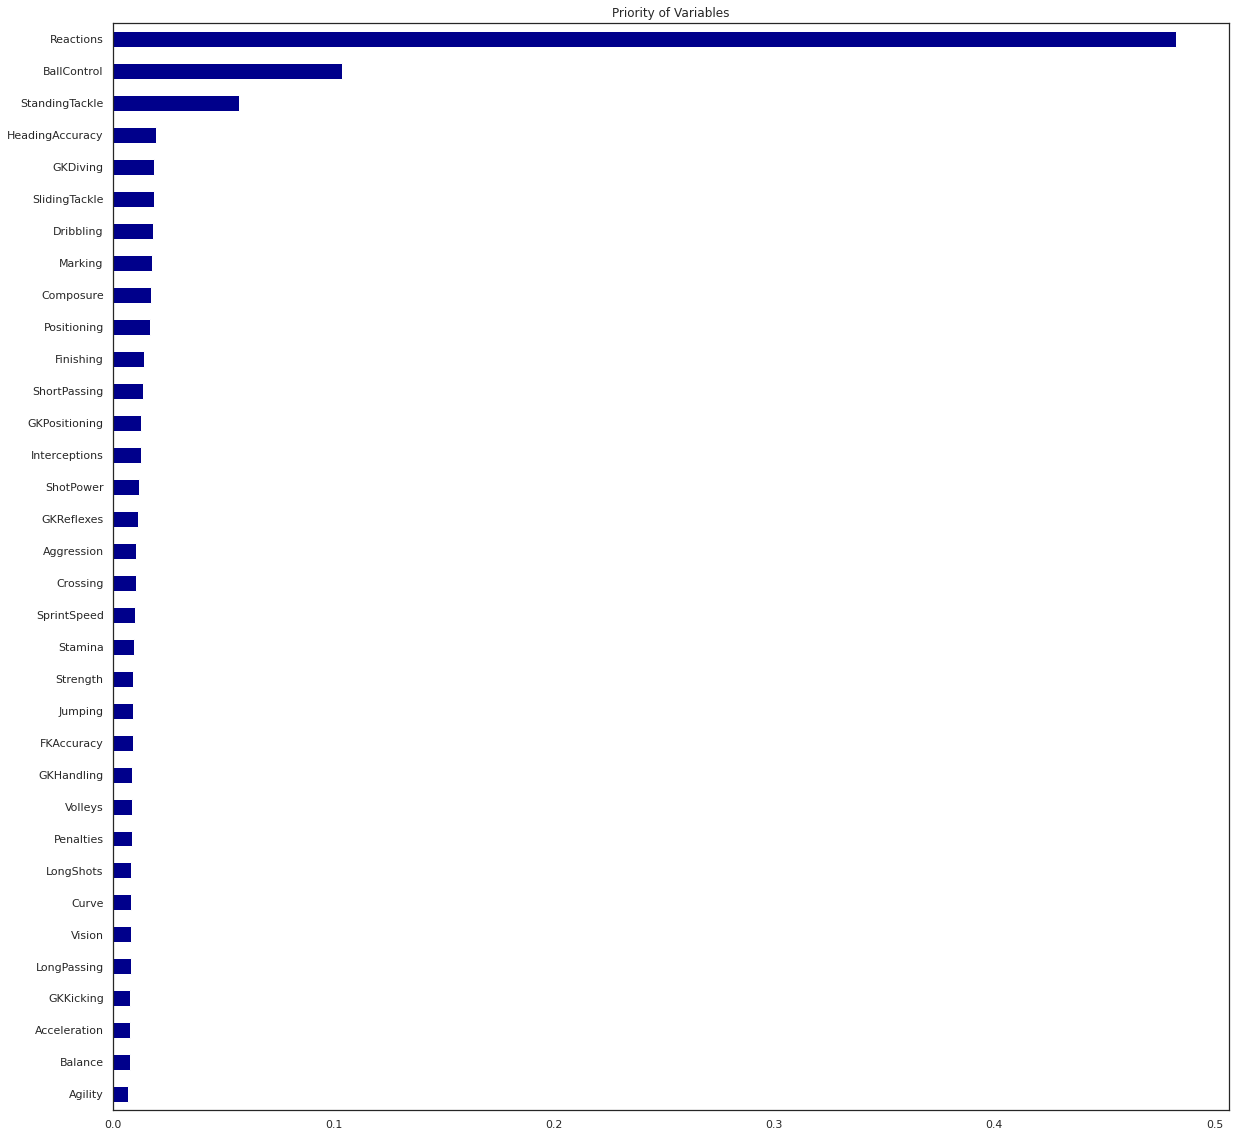

In [174]:
prio = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

prio_ordered = prio.sort_values()
plt.figure(figsize=(20,20))
prio_ordered.plot(kind='barh', color='darkblue')

plt.title('Priority of Variables')
plt.show()